# Clone repo

In [ ]:
!git clone https://github.com/taslimamindia/NERC.git

In [ ]:
# download('wordnet') # for google colab
# download('stopwords')

# Class

## Importation

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf
import os

from keras.utils import to_categorical, pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from keras.layers import LSTM, Dense


## Class define form data.

In [105]:
class Data(object):
    unique_words = {"<PAD>": 0}
    unique_ner_tags = {"O": 0}
    unique_chunk_tags = {}
    unique_pos_tags = {}
    MAX_LENGTH = 50
    VOCAB_SIZE = 100
    BATCH_SIZE = 5

    def __init__(self):
        self.sentences = []
        self.sentences_num = []
        self.ner_tags = []
        self.ner_tags_num = []
        self.chunk_tags = []
        self.pos_tags = []
        self.features = []
        self.x, self.y = None, None

    def __add__(self, o):
        data = Data()
        data.sentences = self.sentences + o.sentences
        data.sentences_num = self.sentences_num + o.sentences_num
        data.ner_tags = self.ner_tags + o.ner_tags
        data.ner_tags_num = self.ner_tags_num + o.ner_tags_num
        data.chunk_tags = self.chunk_tags + o.chunk_tags
        data.pos_tags = self.pos_tags + o.pos_tags
        return data

    def word2idx(self, word: str):
        return Data.unique_words.get(word, None)

    def idx2word(self, index: int):
        for word, value in Data.unique_words.items():
            if index is value:
                return word
        return None

    def tag2idx(self, tag):
        return Data.unique_ner_tags.get(tag, None)

    def idx2tag(self, index):
        for tag, value in Data.unique_ner_tags.items():
            if index == value:
                return tag
        return None

    def __unicity_tag(self, dico: dict, listes: list):
        unique_word = set()
        [unique_word.update(tags) for tags in listes]
        max_index = len(dico)
        for word in list(unique_word):
            if dico.get(word, None) == None:
                dico[word] = max_index
                max_index += 1

    def unicity(self):
        self.__unicity_tag(Data.unique_ner_tags, self.ner_tags_num)
        self.__unicity_tag(Data.unique_words, self.sentences_num)
        self.__unicity_tag(Data.unique_chunk_tags, self.chunk_tags)
        self.__unicity_tag(Data.unique_pos_tags, self.pos_tags)

    def features_level(self):
        def is_capitalize(word):
            return len(word) > 1 and word[0].isupper() and word[1:].islower()
        features = [
            [
                [is_capitalize(word), word.isupper(), word.islower(), word.istitle(), word.isdigit()]
                for word in sentence
            ]
            for sentence in self.sentences
        ]
        self.features = [[[int(f) for f in feat] for feat in feature] for feature in features]

## Use Functions

In [ ]:
sents = margin(lstm.train.sentences_num, 5)
sents = flatting(sents)
sents = np.array(sents, dtype="float32")
print(sents.shape)

In [42]:
class Model_Word2Vec:
    def __init__(self, sentences):
        self.model = Word2Vec(
            sentences=sentences, min_count=1, vector_size=Data.VOCAB_SIZE, window=5
        )

    def wv(self, word):
        return self.model.wv[word]

def flatting(sentences):
    return [word for sentence in sentences for word in sentence]

def margin(sentences, batch_size):
    """Permet d'ajouter du marge sur les bords.

    Args:
        sentences (list[list]): _description_
        batch_size (int): _description_

    Returns:
        list[list]: _description_

    Example:
        input: ['Peter', 'Blackburn']
        output ['<pad>', 'Blackburn', 'Peter', 'Blackburn', '<pad>']
    """
    b_size = int(batch_size // 2)
    pad = [np.zeros(shape=sentences[0][0].shape)]
    def __pad(sentence: list):
        n = len(sentence)
        if n <= b_size:
            sentence = sentence + pad * (b_size - n + 1)
            n = len(sentence)
        sentence = (
            list(reversed(sentence[1 : b_size + 1]))
            + sentence
            + list(reversed(sentence[n - b_size - 1 : n - 1]))
        )
        n = len(sentence)
        Sentences = []
        for i in range(b_size, n - b_size):
            Sentences.append(np.array(sentence[i - b_size : i + b_size + 1], dtype="float32"))
        
        
        return Sentences
    
    Sentences = [__pad(sentence.copy()) for sentence in sentences]
    Sentences = [[Sentences[i][j] for j in range(len(sentences[i]))] for i in range(len(sentences))]
    return Sentences


def zip_2D(*args):
    zipdata = list(zip(args[0], args[1], args[2], args[3]))
    return [list(zip(data[0], data[1], data[2], data[3])) for data in zipdata]


def unzip_2D(args):
    words, ners, chunks, poss = [], [], [], []
    for arg in args:
        word, ner, chunk, pos = [], [], [], []
        for triple in arg:
            word.append(triple[0])
            ner.append(triple[1])
            chunk.append(triple[2])
            pos.append(triple[3])
        words.append(word)
        ners.append(ner)
        chunks.append(chunk)
        poss.append(pos)
    return words, ners, chunks, poss


def padding(data: Data):
    data.flatten()
    data.x = data.sentences_num
    data.y = data.ner_tags
    data.gather()
    data.sentences_num = data.x
    data.ner_tags_num = data.y


def evaluation(test: Data, y_predict):
    true, false, total, predict = 0, 0, 0, 0
    x, y, z = test.y.shape
    for i in range(x):
        for j in range(y):
            real_tag = np.argmax(test.y[i][j])
            predict_tag = np.argmax(y_predict[i][j])
            if predict_tag == 0:
                predict += 1
            if real_tag != 0:
                total = total + 1
                if real_tag == predict_tag:
                    true = true + 1
                else:
                    false = false + 1
    print("----------------------- Evaluation -------------------------")
    print(test.y.shape)
    print(predict, x * y)
    print(
        true, false, total, round(true / total, 3), round(false / total, 3), end="\n\n"
    )


def checkDataset(train, test, valid):
    print("X_train", train.x.shape, "y_train", train.y.shape, "\n")
    print("X_test", test.x.shape, "y_test", test.y.shape, "\n")
    print("X_valid", valid.x.shape, "y_valid", valid.y.shape)

## Loading data

In [106]:
class Loading():
    def __init__(self, path):
        if os.path.exists("../Data/conll2003_english/"): 
            base_file = "../Data/conll2003_english/"
        else:
            base_file = "/content/NERC/Data/conll2003_english/"        
        self.data = Data()
        self.load_sentences(base_file + path)
    def load_sentences(self, filepath):
        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                    if len(tokens) > 0:
                        self.data.sentences.append(tokens)
                        self.data.pos_tags.append(pos_tags)
                        self.data.chunk_tags.append(chunk_tags)
                        self.data.ner_tags.append(ner_tags)
                        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
                else:
                    l = line.split(' ')
                    tokens.append(l[0])
                    pos_tags.append(l[1])
                    chunk_tags.append(l[2])
                    ner_tags.append(l[3].strip('\n'))
            self.data.sentences_num = self.data.sentences
            self.data.ner_tags_num = self.data.ner_tags

## Preprocessing

In [107]:
class Preprocessing:
    def __init__(self, data: Data, text=None, lang="english"):
        self.data = data
        self.text = text
        self.lang = lang

    def tokenize(self):
        if self.text != None:
            sentenses = [
                word_tokenize(sentence, language=self.lang)
                for sentence in sent_tokenize(self.text, language=self.lang)
            ]
            self.data.sentences = [
                [token for token in sentence if token not in stopwords.words(self.lang)]
                for sentence in sentenses
            ]
            self.data.sentences_num = self.data.sentences

    def lowercasing(self):
        self.data.sentences_num = [
            [word.lower() for word in sentence] for sentence in self.data.sentences_num
        ]

    def lemmatize(self):
        lemmatizer = WordNetLemmatizer()
        self.data.sentences_num = [
            [lemmatizer.lemmatize(word) for word in sentence]
            for sentence in self.data.sentences_num
        ]

    def remove_stopword(self):
        punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
        punctuations = stopwords.words(self.lang) + punctuation
        sentences = zip_2D(
            self.data.sentences_num,
            self.data.ner_tags_num,
            self.data.chunk_tags,
            self.data.pos_tags,
        )
        sentences = [
            [
                triple
                for triple in sentence
                if triple[0] not in punctuations or triple[1] != "O"
            ]
            for sentence in sentences
        ]
        (
            self.data.sentences_num,
            self.data.ner_tags_num,
            self.data.chunk_tags,
            self.data.pos_tags,
        ) = unzip_2D(sentences)

## Vectorization

In [110]:
class Vectorization:
    # path = "E:\\word2vec\\gensim-data\\word2vec-google-news-300\\GoogleNews-vectors-negative300.bin"
    # word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

    def __init__(self, data: Data, word2vec_model: Model_Word2Vec):
        self.data = data
        self.word2vec_model = word2vec_model

    def word2vec(self):
        Sentences = []
        for sentence in self.data.sentences_num:
            Sentence = []
            for word in sentence:
                try:
                    # Sentence.append(self.word2vec_model.get_vector(word))
                    Sentence.append(self.word2vec_model.wv(word))
                except Exception as e:
                    Sentence.append(self.word2vec_model.wv(word))
            Sentences.append(Sentence)
        self.data.sentences_num = Sentences

    def padding_x(self):
        self.data.x = pad_sequences(
            sequences=self.data.sentences_num,
            maxlen=self.data.MAX_LENGTH,
            dtype="float32",
            padding="post",
            value=np.zeros((Data.VOCAB_SIZE,), dtype="float32"),
        )

    def vectorized_x(self):
        self.word2vec()
        self.data.sentences_num = margin(self.data.sentences_num, batch_size=Data.BATCH_SIZE)
        self.data.x = np.array(flatting(self.data.sentences_num), dtype="float32")
        # self.padding_x()

    def tag2num(self):
        self.data.ner_tags_num = [
            [Data.unique_ner_tags.get(tag) for tag in tags]
            for tags in self.data.ner_tags_num
        ]

    def num2oneHotEncoding(self):
        NUM_CLASSES = len(Data.unique_ner_tags)
        self.data.ner_tags_num = [
            to_categorical(tags, num_classes=NUM_CLASSES)
            for tags in self.data.ner_tags_num
        ]

    def padding_y(self):
        self.data.y = pad_sequences(
            sequences=self.data.ner_tags_num,
            maxlen=self.data.MAX_LENGTH,
            padding="post",
            dtype="float32",
            value=to_categorical(
                Data.unique_ner_tags.get("O"), num_classes=len(Data.unique_ner_tags)
            ),
        )

    def vectorized_y(self):
        self.tag2num()
        self.num2oneHotEncoding()
        self.data.y = np.array(flatting(self.data.ner_tags_num), dtype="float32")
        # self.padding_y()

# Main

## Parameter

### Visualization

In [77]:
train = Loading("train.txt").data
test = Loading("test.txt").data
valid = Loading("valid.txt").data

In [61]:
class Visualisation:
    def __init__(self, train, test=None, valid=None, pos: int=0, dim: int = 0):
        X, y = None, None
        if dim == 0:
            if pos == 0:
                Sentences = train.sentences + test.sentences + valid.sentences
                Tags = train.ner_tags + test.ner_tags + valid.ner_tags
            elif pos == 1:
                Sentences = train.sentences_num + test.sentences_num + valid.sentences_num
                Tags = train.ner_tags_num + test.ner_tags_num + valid.ner_tags_num
            X = [word for sentence in Sentences for word in sentence]
            y = [tag for tags in Tags for tag in tags]
            self.df = pd.DataFrame({"word": X, "label": y})
        else:
            if pos == 0:
                X, y = train[0], train[1]
                self.df = pd.DataFrame({"word": np.zeros((X.shape[0])), "label": y})
            elif pos == 1:
                X, y = flatting(train[0]), flatting(train[1])
                self.df = pd.DataFrame({"word": X, "label": y})
    def classNumber(self):
        hist = self.df.groupby("label").count()
        return hist

    def classNumberHistogram(self):
        hist = self.df.groupby("label").count()
        hist = pd.DataFrame({"class":hist.index, "count": hist["word"]})
        hist = hist.to_numpy().tolist()
        cl = [t[0] for t in hist]
        nbr = [t[1] for t in hist]
        sns.barplot(data=pd.DataFrame({"class":cl, "count":nbr}), x="class", y="count")

In [74]:
visualisation = Visualisation(train, test, valid, pos=1, dim=0)

In [63]:
visualisation.classNumber()

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,250660


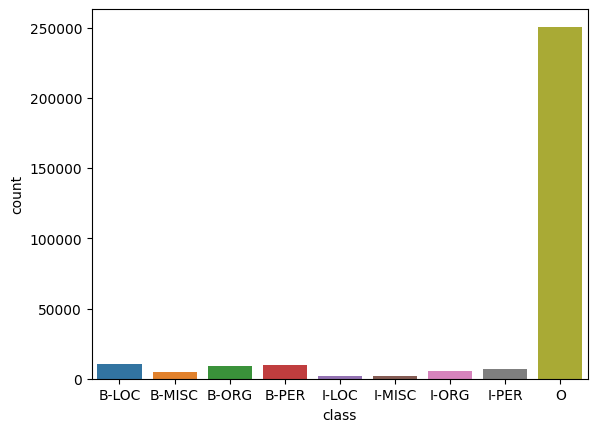

In [58]:
visualisation.classNumberHistogram()

In [59]:
visualisation.df.describe()

,word,label
count,301418,301418
unique,30289,9
top,",",O
freq,10876,250660


In [86]:
data = train + test + valid
preprocess = Preprocessing(data=data)
preprocess.remove_stopword()
visualisation1 = Visualisation((data.sentences_num, data.ner_tags_num), pos=1, dim=1)

In [88]:
visualisation1.classNumber()

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,139920


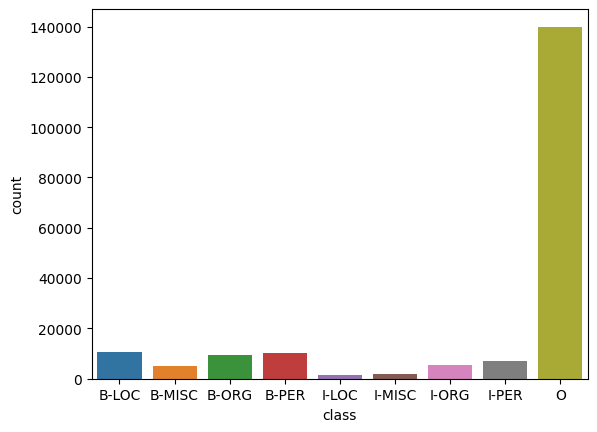

In [90]:
visualisation1.classNumberHistogram()

### New input text

In [ ]:
# test_text = Data()

# preprocessing = Preprocessing(data = test_text, text = "Obama is the president of the United States. I am from Guinea, nice to meet you.")
# preprocessing.tokenize()
# preprocessing.lowercasing()
# preprocessing.lemmatize()
# print(test_text.sentences)

# vector = Vectorization(test_text)
# vector.vectorized_x()
# print(test_text.x.shape)

### Parameters

In [109]:
# Hyperparameters
NUM_FILTERS = 256
KERNEL_SIZE = 3
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

## Models

### Base Model

In [114]:
class Base_Model:
    def __init__(self, train=True, test=True, valid=True):
        if train: self.train = Loading("train.txt").data
        else: self.train = None
        if test: self.test = Loading("test.txt").data
        else: self.test = None
        if valid: self.valid = Loading("valid.txt").data
        else: self.valid = None
        self.model = None
        
    def compress(self):
        self.train = self.train + self.test + self.valid
        
    def change(self, max_length=None, vocab_size=None, batch_size=None):
        if max_length != None:
            Data.MAX_LENGTH = max_length
        if vocab_size != None:
            Data.VOCAB_SIZE = vocab_size
        if batch_size != None:
            Data.BATCH_SIZE = batch_size

    def preprocess(self, data: Data):
        preprocessing = Preprocessing(data=data)
        # preprocessing.lowercasing()
        # preprocessing.lemmatize()
        preprocessing.remove_stopword()
        data.unicity()

    def preprocessing(self):
        if self.train != None: self.preprocess(self.train)
        # if self.test != None: self.preprocess(self.test)
        # if self.valid != None: self.preprocess(self.valid)

    def vectorize(self, data: Data, model_wv: Model_Word2Vec):
        vector = Vectorization(data=data,word2vec_model=model_wv)
        vector.vectorized_x()
        vector.vectorized_y()

    def vectorization(self, model_wv: Model_Word2Vec):
        if self.train != None: self.vectorize(self.train, model_wv)
        # if self.test != None: self.vectorize(self.test)
        # if self.valid != None: self.vectorize(self.valid)

    def summary(self):
        self.model.summary()

    def trainning(self, optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        if self.valid == None:
            self.model.fit(self.train.x, self.train.y, batch_size=BATCH_SIZE, epochs=EPOCHS)
        else:
            self.model.fit(
                self.train.x,
                self.train.y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(self.valid.x, self.valid.y),
            )

    def testing(self):
        return self.model.evaluate(self.test.x, self.test.y)

    def predicting(self):
        y_predict = self.model.predict(self.test.x, batch_size=BATCH_SIZE)
        evaluation(self.test, y_predict)

### CNN model

#### Class model CNN

In [130]:
class Model_CNN(Base_Model):
    def __init__(self, train=True, test=True, valid=True):
        super().__init__(train=train, test=test, valid=valid)
        
    def architecture(self, activation='sigmoid'):
        # Define the model architecture
        self.model = Sequential()
        self.model.add(
            Conv1D(
                128,
                KERNEL_SIZE,
                activation="relu",
                input_shape=(Data.BATCH_SIZE, Data.VOCAB_SIZE),
                padding="same",
            )
        )
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Conv1D(64, KERNEL_SIZE, activation="relu", padding="same"))
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Conv1D(32, KERNEL_SIZE, activation="relu", padding="same"))
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Dense(len(Data.unique_ner_tags), activation=activation))

    # def architecture_1D(self, activation='sigmoid'):
    #     # Define the model architecture
    #     self.model = Sequential()
    #     self.model.add(
    #         Conv1D(
    #             128,
    #             KERNEL_SIZE,
    #             activation="relu",
    #             input_shape=(1, Data.VOCAB_SIZE),
    #             padding="same",
    #         )
    #     )
    #     self.model.add(Dropout(DROPOUT_RATE))
    #     self.model.add(Conv1D(64, KERNEL_SIZE, activation="relu", padding="same"))
    #     self.model.add(Dropout(DROPOUT_RATE))
    #     self.model.add(Conv1D(32, KERNEL_SIZE, activation="relu", padding="same"))
    #     self.model.add(Dropout(DROPOUT_RATE))
    #     self.model.add(Dense(len(Data.unique_ner_tags), activation=activation))

#### Test model CNN

In [131]:
cnn = Model_CNN()
cnn.change(50, 300, 5)
cnn.compress()
model_wv = Model_Word2Vec(cnn.train.sentences)
cnn.train.features_level()
cnn.preprocessing()
cnn.vectorization(model_wv=model_wv)

In [132]:
print(cnn.train.x.shape, cnn.train.y.shape)

(190678, 5, 300) (190678, 9)


In [133]:
cnn.architecture()
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 128)            115328    
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 32)             6176      
                                                                 
 dropout_2 (Dropout)         (None, 5, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 5, 9)             

### Model LSTM

#### Class model LSTM

In [128]:
class Model_LSTM(Base_Model):
    def __init__(self, train=True, test=True, valid=True):
        super().__init__(train=train, test=test, valid=valid)
    
    def architecture(self):
        # Define the model architecture
        self.model = Sequential()
        self.model.add(
            LSTM(
                256,
                input_shape=(Data.BATCH_SIZE, Data.VOCAB_SIZE),
                return_sequences=True,
                dropout=DROPOUT_RATE,
            )
        )
        self.model.add(LSTM(128, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(LSTM(64, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(LSTM(32, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(Dense(len(Data.unique_ner_tags), activation="sigmoid"))

    # def model_1D(self):
    #     # self.model.add(
    #     #     LSTM(
    #     #         256,
    #     #         input_shape=(Data.VOCAB_SIZE,), return_state=True
    #     #     )
    #     # )
    #     # # self.model.add(LSTM(128))
    #     # # self.model.add(LSTM(64))
    #     # # self.model.add(LSTM(32))
    #     # self.model.add(Dense(len(Data.unique_ner_tags), activation="sigmoid"))

    #     input = tf.keras.Input(shape=(Data.VOCAB_SIZE,))
    #     # model = Dropout(0.5)(model)
    #     model = tf.keras.layers.Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
    #     out = tf.keras.layers.TimeDistributed(Dense(9, activation="softmax"))(model)  # softmax output layer
    #     self.model = tf.keras.Model(input, out)

#### Test model LSTM

In [126]:
lstm = Model_LSTM()
lstm.change(50, 300, 5)
lstm.compress()
model_wv = Model_Word2Vec(lstm.train.sentences)
lstm.train.features_level()
lstm.preprocessing()
lstm.vectorization(model_wv=model_wv)

In [127]:
print(lstm.train.x.shape, lstm.train.y.shape)

(190678, 5, 300) (190678, 9)


In [129]:
lstm.architecture()
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 256)            570368    
                                                                 
 lstm_5 (LSTM)               (None, 5, 128)            197120    
                                                                 
 lstm_6 (LSTM)               (None, 5, 64)             49408     
                                                                 
 lstm_7 (LSTM)               (None, 5, 32)             12416     
                                                                 
 dense_1 (Dense)             (None, 5, 9)              297       
                                                                 
Total params: 829,609
Trainable params: 829,609
Non-trainable params: 0
_________________________________________________________________


### TF-IDF

In [ ]:
# from keras.optimizers import Adam
# from imblearn.over_sampling import SMOTE


# def balanceData(data):
#     x_train = np.array(data.sentences_num, dtype="float32")
#     y_train = np.array(data.ner_tags_num, dtype="float32")
#     print(x_train.shape, y_train.shape)
#     input_dim = x_train.shape[1]

#     # Encoder
#     encoder_input = tf.keras.Input(shape=(input_dim,))
#     encoder_dense = tf.keras.layers.Dense(400, activation="relu")(encoder_input)
#     encoder_output = tf.keras.layers.Dense(input_dim, activation="relu")(encoder_dense)

#     # Decoder
#     decoder_dense = tf.keras.layers.Dense(400, activation="relu")(encoder_output)
#     decoder_output = tf.keras.layers.Dense(input_dim, activation="sigmoid")(
#         decoder_dense
#     )

#     # Autoencoder
#     autoencoder = tf.keras.Model(encoder_input, decoder_output)
#     autoencoder.compile(
#         optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"]
#     )
#     # print(autoencoder.summary())

#     # Train the autoencoder
#     autoencoder.fit(x_train, x_train, epochs=10, batch_size=32)

#     # Extract latent space representation
#     encoder = tf.keras.Model(encoder_input, encoder_output)
#     x_train_predict = encoder.predict(x_train)

#     # Class balancing with SMOTE or any other technique adadelta
#     smote = SMOTE()
#     x_train_balanced, y_train_balanced = smote.fit_resample(x_train_predict, y_train)
#     return x_train_balanced, y_train_balanced

#### train set

In [ ]:
lstm.preprocess(lstm.train)
vector = Vectorization(lstm.train)
vector.word2vec()
# vector.tag2num()
# vector.num2oneHotEncoding()
# lstm.train.flatten()
# lstm.train.x, lstm.train.y = balanceData(lstm.train)

In [ ]:
print(len(lstm.train.sentences),len(lstm.train.sentences_num))

In [ ]:
lstm.train.gather()
lstm.train.x = np.array(lstm.train.x, dtype="float32")
lstm.train.ner_tags_num = lstm.train.y
lstm.train.y = np.array(lstm.train.ner_tags_num, dtype="float32")
print(lstm.train.x.shape, lstm.train.y.shape)

#### valid set

In [ ]:
lstm.valid = Loading("valid.txt").data

In [ ]:
lstm.preprocess(lstm.valid)
vector = Vectorization(lstm.valid)
vector.word2vec()
vector.tag2num()
vector.num2oneHotEncoding()
lstm.valid.flatten()
lstm.valid.x, lstm.valid.y = balanceData(lstm.valid)
lstm.valid.gather()
lstm.valid.x = np.array(lstm.valid.x, dtype="float32")
lstm.valid.ner_tags_num = lstm.valid.y
lstm.valid.y = np.array(lstm.valid.ner_tags_num, dtype="float32")
print(lstm.valid.x.shape, lstm.valid.y.shape)

#### Test set

In [ ]:
lstm.preprocess(lstm.test)
padding(lstm.test)
lstm.vectorize(lstm.test)

In [ ]:
# checkDataset(lstm.train, lstm.test, lstm.valid)

In [ ]:
# lstm.model=Sequential()

In [ ]:
lstm.model_2D()
lstm.summary()

In [ ]:
lstm.valid=None
lstm.trainning()
lstm.predicting()

In [ ]:
# import numpy as np
# from gensim.models import Word2Vec
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# from sklearn.utils import class_weight

# # Step 1: Load and preprocess the data

# # Assuming you have a list of sentences and their corresponding labels
# sentences = ["This is sentence 1", "Another sentence", "Yet another sentence"]
# labels = [1, 0, 1]  # Assuming binary labels (e.g., 0 - non-NER, 1 - NER)

# # Step 2: Train Word2Vec model

# # Tokenize the sentences
# tokenized_sentences = [sentence.lower().split() for sentence in sentences]

# # Train Word2Vec model
# word2vec_model = Word2Vec(tokenized_sentences, size=100, window=5, min_count=1)

# # Step 3: Encode sentences using Word2Vec embeddings

# # Encode sentences into Word2Vec embeddings
# encoded_sentences = []
# for sentence in tokenized_sentences:
#     sentence_encoding = []
#     for word in sentence:
#         if word in word2vec_model.wv.vocab:
#             sentence_encoding.append(word2vec_model.wv[word])
#     encoded_sentences.append(sentence_encoding)

# # Pad sequences to the same length
# padded_sentences = pad_sequences(encoded_sentences, maxlen=max_length, padding='post')

# # Step 4: Build and train the autoencoder for imbalanced data

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(padded_sentences, labels, test_size=0.2, random_state=42)

# # Calculate class weights to address class imbalance
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# # Build the autoencoder model
# autoencoder = Sequential()
# autoencoder.add(Dense(64, activation='relu', input_shape=(max_length, 100)))
# autoencoder.add(Dense(32, activation='relu'))
# autoencoder.add(Dense(64, activation='relu'))
# autoencoder.add(Dense(100, activation='relu'))

# # Compile and train the autoencoder
# autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(X_train, X_train, epochs=10, batch_size=16, class_weight=class_weights)

# # Step 5: Extract features using LSTM

# # Build the LSTM model
# lstm_model = Sequential()
# lstm_model.add(LSTM(64, input_shape=(max_length, 100)))
# lstm_model.add(Dense(1, activation='sigmoid'))

# # Compile and train the LSTM model
# lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
# lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, class_weight=class_weights)

# # Step 6: Make predictions

# # Predict on test data
# y_pred = lstm_model.predict(X_test)

# # Convert predictions to labels
# y_pred_labels = [1 if pred > 0.5 else 0 for pred in y_pred]

# # Evaluate the model
# accuracy = np.mean(np.array(y_pred_labels) == np.array(y_test))
# print("Accuracy:", accuracy)


In [ ]:
visualisation1 = Visualisation(train = (x_train_balanced, y_train_balanced), dim=1)

In [ ]:
visualisation1.classNumber()

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras.optimizers import Adam

# # Generate synthetic balanced multilabel data
# num_samples = 1000
# num_features = 50
# num_labels = 10
# data = np.random.rand(num_samples, num_features)
# labels = np.random.randint(2, size=(num_samples, num_labels))
# labels_balanced = np.column_stack((labels[:, :5], np.logical_not(labels[:, :5])))
# print(labels_balanced[0])
# # Split the data into training and testing sets
# train_data, test_data, train_labels, test_labels = train_test_split(data, labels_balanced, test_size=0.2, random_state=42)
# print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)
# # Autoencoder architecture
# input_dim = num_features
# encoding_dim = 20

# input_layer = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation='relu')(input_layer)
# decoder = Dense(input_dim, activation='sigmoid')(encoder)

# # Create the autoencoder model
# autoencoder = Model(inputs=input_layer, outputs=decoder)

# # Compile the model
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# # Train the autoencoder
# autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, shuffle=True, validation_data=(test_data, test_data))
# autoencoder.summary()
# # Extract the encoder part for feature representation
# encoder_model = Model(inputs=input_layer, outputs=encoder)

# # Get the encoded features
# encoded_train_features = encoder_model.predict(train_data)
# encoded_test_features = encoder_model.predict(test_data)


In [ ]:
# import numpy as np
# import tensorflow as tf
# from keras import layers
# from keras.utils import to_categorical

# # Define your autoencoder model
# input_dim = 200
# encoding_dim = 64

# autoencoder_input = tf.keras.Input(shape=(input_dim,))
# encoded = layers.Dense(encoding_dim, activation='relu')(autoencoder_input)
# decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# autoencoder = tf.keras.Model(autoencoder_input, decoded)

# # Compile the model
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# # Generate imbalanced training data
# x_train = np.random.rand(1000, 200)
# y_train = np.random.choice([0, 1], size=(1000,), p=[0.9, 0.1])
# y_train = to_categorical(y_train, num_classes=2)  # Convert labels to one-hot encoding

# print(autoencoder.summary())
# print("train", x_train.shape, y_train.shape)

# # Train the autoencoder
# autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=True)

# # Obtain the encoded representations
# encoder = tf.keras.Model(autoencoder_input, encoded)
# encoded_train = encoder.predict(x_train)
# print(encoded_train.shape)

#### Class model TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class TF_IDF:
    def __init__(self, train:Data=None, test:Data=None, valid:Data=None):
        if train == None:
          self.train = Loading("train.txt").data
        else:
          self.train = train
        if test == None:
          self.test = Loading("test.txt").data
        else:
          self.test = test
        if valid == None:
          self.valid = Loading("valid.txt").data
        else:
          self.valid = valid

    def __preprocess_tfidf(self, data: Data):
        preprocessing = Preprocessing(data=data)
        preprocessing.lowercasing()
        preprocessing.lemmatize()
        preprocessing.remove_stopword()
        data.unicity()

    def preprocessing(self):
        self.__preprocess_tfidf(self.train)
        self.__preprocess_tfidf(self.test)
        self.__preprocess_tfidf(self.valid)

    def __getMatrix(self, max_length, tfidf_matrix, data: Data, feature_names):
        entities_data = []
        for doc_index in range(len(data.sentences_num)):
            doc_tfidf_scores = tfidf_matrix[doc_index].toarray().flatten()
            top_indices = doc_tfidf_scores.argsort()[: -doc_tfidf_scores.shape[0] - 1 : -1]
            top_entities = [feature_names[i] for i in top_indices if feature_names[i].split("__")[1] != "O"]
            doc_entities = [entitie for entitie in list(top_entities)[:max_length]]
            entities_data.append(doc_entities)
        data.sentences_num = entities_data

    def __formalize_tfidf(self, data: Data):
        return [
            " ".join(["".join([word, "__", tag]) for word, tag in zip(words, tags)])
            for words, tags in zip(data.sentences_num, data.ner_tags_num)
        ]

    def __deformalize_tfidf(self, data: Data):
        sentences_tags = data.sentences_num
        data.sentences_num = [[sent_tag.split("__")[0] for sent_tag in sentences_tags] for sentences_tags in sentences_tags]
        data.ner_tags_num = [[sent_tag.split("__")[1] for sent_tag in sentences_tags] for sentences_tags in sentences_tags]

    def vectorization(self):
        vectorizer = TfidfVectorizer(
            lowercase=False,
            analyzer="word",
            stop_words=None,
            token_pattern="[\S]+",
            tokenizer=None,
            preprocessor=None,
        )
        # formatted
        data_train = self.__formalize_tfidf(self.train)
        data_test = self.__formalize_tfidf(self.test)
        data_valid = self.__formalize_tfidf(self.valid)
        # Tf-idf vectorization
        tfidf_matrix_train = vectorizer.fit_transform(data_train)
        tfidf_matrix_test = vectorizer.transform(data_test)
        tfidf_matrix_valid = vectorizer.transform(data_valid)
        feature_names = vectorizer.get_feature_names_out()
        # Generation of the matrix
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_train, self.train, feature_names)
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_test, self.test, feature_names)
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_valid, self.valid, feature_names)
        # unformatted
        self.__deformalize_tfidf(self.train)
        self.__deformalize_tfidf(self.test)
        self.__deformalize_tfidf(self.valid)

#### Test model TF-IDF

In [ ]:
tfidf = TF_IDF()
tfidf.preprocessing()
tfidf.vectorization()

In [ ]:
i = 150
list(zip(tfidf.test.sentences_num[i], tfidf.test.ner_tags_num[i]))

In [ ]:
train = Loading("train.txt").data
test = Loading("test.txt").data
valid = Loading("valid.txt").data
visualisation = Visualisation(train, test, valid, 0)
visualisation.classNumber()

In [ ]:
visualisation2 = Visualisation(tfidf.train, tfidf.test, tfidf.valid, 1)
visualisation2.classNumber()

In [ ]:
visualisation2.classNumberHistogram()

## Tools

In [ ]:
# import gensim.downloader as api
# path = api.load("word2vec-google-news-300", return_path=True)
# print(path)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D

# # Load data
# df = pd.read_csv("ner_data.csv", encoding="ISO-8859-1", error_bad_lines=False)
# df = df.fillna(method="ffill")
# sentences = df.groupby("Sentence #")["Word"].apply(list).values
# tags = df.groupby("Sentence #")["Tag"].apply(list).values

# # Perform TF-IDF
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# X_tfidf = vectorizer.fit_transform([" ".join(sent) for sent in sentences])
# tfidf_vocab = vectorizer.vocabulary_
# tfidf_vocab_inv = {v:k for k,v in tfidf_vocab.items()}
# tfidf_weights = np.asarray(X_tfidf.mean(axis=0)).ravel()

# # Tokenize words
# MAX_NB_WORDS = 20000
# MAX_SEQ_LENGTH = 100
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index

# # Convert words to sequences
# X = tokenizer.texts_to_sequences(sentences)
# X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)

# # Convert tags to sequences
# tags_index = {"O": 0, "B-LOC": 1, "I-LOC": 2, "B-PER": 3, "I-PER": 4, "B-ORG": 5, "I-ORG": 6}
# y = [[tags_index[tag] for tag in sent] for sent in tags]
# y = pad_sequences(y, maxlen=MAX_SEQ_LENGTH)

# # Split data into train and test sets
# VALIDATION_SPLIT = 0.2
# nb_validation_samples = int(VALIDATION_SPLIT * len(X))
# X_train = X[:-nb_validation_samples]
# y_train = y[:-nb_validation_samples]
# X_test = X[-nb_validation_samples:]
# y_test = y[-nb_validation_samples:]

# # Define CNN model
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, Data.VOCAB_SIZE, input_length=MAX_SEQ_LENGTH))
# model.add(Conv1D(128, 5, activation="relu"))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(7, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Train model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

# # Predict tags for new sentences
# def predict_tags(sentences):
#     X = tokenizer.texts_to_sequences(sentences)
#     X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)
#     y_pred = model.predict(X)
#     return [[tfidf_vocab_inv[np.argmax(tfidf_weights * y)] if np.max(tfidf_weights * y) > 0.2 else "O" for y in sent] for sent in y_pred]

# # Test predictions
# sentences_test = ["John lives in New York City.", "Steve Jobs was the founder of Apple."]
# tags_pred = predict_tags(sentences_test)
# print(tags_pred)

In [ ]:
# !pip install tensorflow-addons

In [ ]:
# model_LSTM.save("../Data/model_lstm.keras")

In [ ]:
# model_LSTM = tf.keras.models.load_model("../Data/model_lstm.keras")

In [ ]:
# # np.quantile(sort([1, 2, 3, 8, 7]), 0.50)
# dico = {}
# for tags in test.sentences + train.sentences + valid.sentences:
#   if dico.get(len(tags), None) == None:
#     dico[len(tags)] = 1
#   dico[len(tags)] += 1
# sorted(list(dico.items()), key= lambda x: x[1])

In [ ]:
# entities = dict(zip(Data.unique_ner_tags.keys(), [0 for i in range(len(Data.unique_ner_tags))]))
# for tags in test.ner_tags:
#     for tag in tags:
#         entities[tag] += 1
# is_entities = 0
# is_not_entities = 0
# for tag, nbr in entities.items():
#     if tag != 'O': is_entities += nbr
#     else: is_not_entities += nbr
# print(entities)
# print(is_entities, is_not_entities)

# Brouillon

In [ ]:
# Build CNN model
model = Sequential()
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, activation='relu', input_shape=(MAX_SEQ_LENGTH, EMBEDDING_DIM)))
model.add(MaxPooling1D(2))
model.add(Dropout(DROPOUT_RATE))
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(HIDDEN_DIM, activation='relu'))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(len(labels), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras import Input, Model
from keras.layers import concatenate, Dense

# define two sets of inputs
inputA = Input(shape=(32,), name="x_input")
inputB = Input(shape=(128,), name="y_input")
# the first branch operates on the first input
x = Dense(8, name="x1", activation="relu")(inputA)
x = Dense(4, name="x2", activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64,name="y1",  activation="relu")(inputB)
y = Dense(32,name="y2",  activation="relu")(y)
y = Dense(4, name="y3", activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, name="z1", activation="relu")(combined)
z = Dense(1, name="z2", activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.summary()